In [1]:
import pickle

with open('../data/processed/train-processed.pkl', 'rb') as f:
    train = pickle.load(f)
    
with open('../data/processed/test-processed.pkl', 'rb') as f:
    test = pickle.load(f)
    
train.columns.to_numpy()

array(['Make', 'Vehicle Class', 'Transmission', 'Id', 'Engine Size(L)',
       'Cylinders', 'Fuel Type', 'CO2 Emissions(g/km)',
       'Fuel Consumption City (km/l)', 'Fuel Consumption Hwy (km/l)',
       'Fuel Consumption Comb (km/l)'], dtype=object)

In [2]:
# Bagi data menjadi fitur dan target
features = train.drop('CO2 Emissions(g/km)', axis=1)
target = train['CO2 Emissions(g/km)']

In [3]:
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

def run_model(model, X_train, y_train, X_test, y_test, verbose=True):
    t_0 = time.time()
    if verbose == False:
        model.fit(X_train, y_train, verbose=0)
    else:
        model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    time_taken = time.time() - t_0
    
    print("RMSE = {}".format(rmse))
    
    return model, rmse, time_taken

In [4]:
# Split data for performance testing

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=12345)

Training with Different Models

In [5]:
# Logistic Regression
# from sklearn.linear_model import LogisticRegression
# params_lr = {'penalty': 'l1', 'solver': 'liblinear'}
# model_lr = LogisticRegression(**params_lr)
# model_lr, rmse_lr, tt_lr = run_model(model_lr, X_train, y_train, X_test, y_test)

In [6]:
from xgboost import XGBRegressor

params_xgb = {
    'objective': 'reg:squarederror',  # Specify the objective for regression tasks
    'colsample_bytree': 0.8,          # Fraction of features to be randomly sampled for each tree
    'learning_rate': 0.1,             # Step size shrinkage to prevent overfitting
    'max_depth': 16,                   # Maximum depth of a tree
    'alpha': 10,                      # L1 regularization term on weights
    'n_estimators': 100,              # Number of boosting rounds
    'subsample': 0.8,                 # Fraction of samples used for each boosting round
    'random_state': 42
}

model_xgb = XGBRegressor(**params_xgb)
model_xgb, rmse_xgb, tt_xgb = run_model(model_xgb, X_train, y_train, X_test, y_test)

RMSE = 35.29383356608269


In [12]:
import lightgbm as lgb

train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

params_lgb = {
    'objective': 'regression',  # 'regression' for regression tasks
    'metric': 'rmse',           # Root Mean Squared Error (RMSE) for regression
    'boosting_type': 'gbdt',    # Gradient Boosting Decision Tree
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

num_round = 100

t_0 = time.time()

model_lgb = lgb.train(params_lgb, train_data, num_round, valid_sets=[test_data])
y_pred = model_lgb.predict(X_test, num_iteration=model_lgb.best_iteration)
rmse_lgb = np.sqrt(mean_squared_error(y_test, y_pred))

time_taken = time.time() - t_0
tt_lgb = time_taken

print("RMSE = {}".format(rmse_lgb))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000854 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1148
[LightGBM] [Info] Number of data points in the train set: 95998, number of used features: 10
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 241.850282
RMSE = 36.952016077847176


In [15]:
from sklearn.ensemble import RandomForestRegressor

params_rf = {
    'n_estimators': 100,
    'max_depth': 16,
    'random_state': 12345
}

model_rf = RandomForestRegressor(**params_rf)
model_rf, rmse_rf, tt_rf = run_model(model_rf, X_train, y_train, X_test, y_test)

RMSE = 34.750575751426744


In [40]:
def evaluate(model, test_features, test_labels):
    t_0 = time.time()
    
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    rmse = np.sqrt(mean_squared_error(test_labels, predictions))
    
    time_taken = time.time() - t_0
    
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('RMSE = {:0.2f}%.'.format(rmse))
    
    return model, rmse, time_taken

In [36]:
# Hyperparameter tuning with GridSearchCV
from sklearn.model_selection import GridSearchCV

param_grid = {
    'bootstrap': [True],
    'max_depth': [8, 16, 32, 48],
    # 'max_features': [None, 'sqrt', 'log2', 0.1, 0.5, 0.9],
    # 'min_samples_leaf': [3, 4, 5],
    # 'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

model_rfg = RandomForestRegressor()
model_gs = GridSearchCV(estimator=model_rfg, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# Fit grid search to find the best model
model_gs.fit(X_train, y_train)
model_gs.best_params_

model_gs_best = model_gs.best_estimator_

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] END ......bootstrap=True, max_depth=8, n_estimators=100; total time=  35.3s
[CV] END ......bootstrap=True, max_depth=8, n_estimators=100; total time=  35.3s
[CV] END ......bootstrap=True, max_depth=8, n_estimators=100; total time=  35.4s
[CV] END ......bootstrap=True, max_depth=8, n_estimators=200; total time= 1.3min
[CV] END ......bootstrap=True, max_depth=8, n_estimators=200; total time= 1.3min
[CV] END ......bootstrap=True, max_depth=8, n_estimators=200; total time= 1.3min
[CV] END ......bootstrap=True, max_depth=8, n_estimators=300; total time= 1.9min
[CV] END ......bootstrap=True, max_depth=8, n_estimators=300; total time= 1.9min
[CV] END .....bootstrap=True, max_depth=16, n_estimators=100; total time= 1.2min
[CV] END .....bootstrap=True, max_depth=16, n_estimators=100; total time= 1.2min
[CV] END ......bootstrap=True, max_depth=8, n_estimators=300; total time= 2.0min
[CV] END .....bootstrap=True, max_depth=16, n_es

In [41]:
model_gs, grid_rmse, tt_gs = evaluate(model_gs_best, X_test, y_test)

print('Improvement of {:0.2f}%.'.format( 100 * (grid_rmse - rmse_rf) / rmse_rf))

Average Error: 21.9019 degrees.
RMSE = 34.66%.
Improvement of -0.26%.


RMSE       Time taken
34.659629  14.628955     1
34.750576  56.335748     1
35.293834  7.885281      1
36.952016  0.532557      1
Name: count, dtype: int64


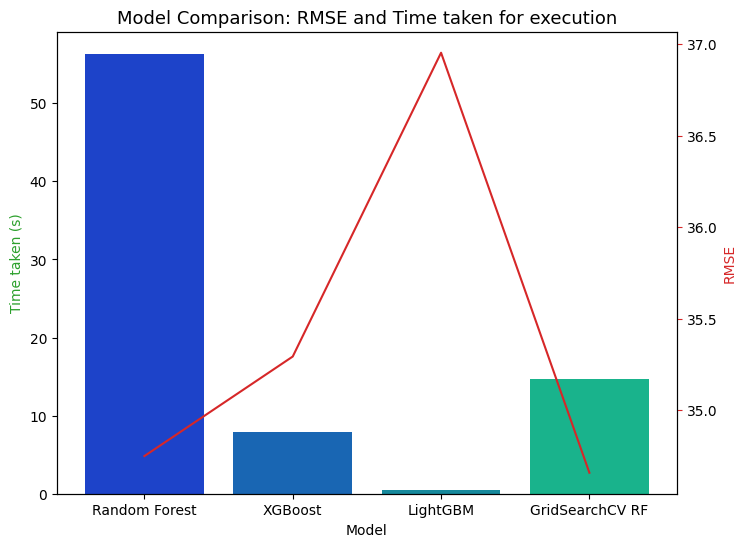

In [42]:
import pandas as pd
import seaborn as sns

rmse = [rmse_rf, rmse_xgb, rmse_lgb, grid_rmse]
tt = [tt_rf, tt_xgb, tt_lgb, tt_gs]

model_data = {'Model': ['Random Forest', 'XGBoost', 'LightGBM', 'GridSearchCV RF'],
              'RMSE': rmse,
              'Time taken': tt}
model_data = pd.DataFrame(model_data)

score = model_data[['RMSE', 'Time taken']].value_counts()
print(score)

fig, ax1 = plt.subplots(figsize=(8,6))
ax1.set_title('Model Comparison: RMSE and Time taken for execution', fontsize=13)
color = 'tab:green'
ax1.set_xlabel('Model', fontsize=10)
ax1.set_ylabel('Time taken (s)', fontsize=10, color=color)
ax2 = sns.barplot(x='Model', y='Time taken', data = model_data, hue='Model', legend=False, palette='winter')
ax1.tick_params(axis='y')
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('RMSE', fontsize=10, color=color)
ax2 = sns.lineplot(x='Model', y='RMSE', data = model_data, sort=False, color=color)
ax2.tick_params(axis='y', color=color)